<a href="https://colab.research.google.com/github/CSCI-1460-Computational-Linguistics/csci-1460-computational-linguistics.github.io/blob/main/f23-projects/project-04/Solution_Causal_Intervention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Causal Mediation Analysis

Consider this sentence from the Winobias dataset: \\

> **Prompt:** The nurse examined the farmer for injuries because she…

Does _she_ refer to the nurse or the farmer in this sentence? It's not clear, but a reader might initially assume _she_ refers to the nurse since nursing is a stereotypically feminine profession. Now consider two different ways to complete the sentence:

> **Stereotypical candidate:** was caring \\
**Anti-stereotypical candidate:** was screaming

In the stereotypical reading, we assume _she_ refers to the nurse, implying the continuation _was caring_. In the anti-stereotypical reading, we instead assume that _she_ refers to the farmer, implying the continuation _was screaming_.

In this project, we want to study how the attention from the gendered pronoun affects the rest of the sentence. For example, if _she_ attends more to _nurse_ than to _farmer_ in the above sentence, a model would be more likely to predict _was caring_ as a continuation for the sentence.

**Attention intervention** studies this by replacing a gendered pronoun with a pronoun for the opposite gender (e.g. replacing _she_ with _he_ in this sentence). We can then pass both sentences through a model and replace the attention heads in the original sentence with those in our new sentence to see how the predictions change.

Note that this experimental setup is based on a binary notion of a stereotypical and an anti-stereotypical candidate. Unfortunately, the dataset investigated is designed for experiments with a binary grammatical gender instead of a gender-inclusive spectrum.

## Resources
This project is adapted from [Causal Mediation Analysis for Interpreting NLP: The Case of Gender Bias](https://arxiv.org/pdf/2004.12265.pdf) (Vig et al, 2020). We recommend reading through the paper to get a better understanding of the project!

Source code for the paper can be found [here](https://github.com/sebastianGehrmann/CausalMediationAnalysis), but we recommend that you use the [TransformerLens library](https://neelnanda-io.github.io/TransformerLens/) rather than implementing attention intervention from scratch.



## Installation (ignore)

In [ ]:
!pip install fancy_einsum

In [ ]:
!pip install circuitsvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.8.0
    Uninstalling importlib-metadata-6.8.0:
      Successfully uninstalled importlib-metadata-6.8.0


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the TransformerLens code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-oqa0_3hc
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-oqa0_3hc
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 54d548de4995a1ecc5b01b9c03aceaf0966c0eb3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from functools import partial
import circuitsvis as cv

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from numpy.linalg import norm
import einops

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy
torch.set_grad_enabled(False)

In [ ]:
import plotly.express as px

In [ ]:
from jaxtyping import Float, Int, Bool
from typing import List, Union, Optional, Callable, Tuple, Dict

update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor"}

def imshow(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

def bar(tensor, renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    px.bar(y=utils.to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

## Data

We will use a subset of the [Winobias dataset](https://uclanlp.github.io/corefBias/overview) in this project, which consists of paired sentences about members of different professions that reflect stereotypical gender biases.

Take our example about the nurse and the farmer from earlier. Our paired sentences in the Winobias dataset that correspond to this example are:

> [The nurse] examined the farmer for injuries because [she] was caring. \\
The nurse examined [the farmer] for injuries because [he] was screaming.

While you don't need to do any additional preprocessing in this section, make sure to look through (especially note the `WinobiasExample` class) so you understand the format of the data!

In [ ]:
examples_selection = [{'base_string': 'The guard appreciated getting treatment from the nurse because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'nurse', 'male_occupation': 'guard', 'female_occupation_continuation': ' did a good job.', 'male_occupation_continuation': ' felt very sick.'},
{'base_string': "The manager agreed to raise the assistant 's salary because {}", 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'assistant', 'male_occupation': 'manager', 'female_occupation_continuation': ' worked very hard.', 'male_occupation_continuation': ' is a generous man.'},
{'base_string': "The carpenter tried to prepare for the auditor 's visit but {}", 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'auditor', 'male_occupation': 'carpenter', 'female_occupation_continuation': ' demanded too much.', 'male_occupation_continuation': ' did not have the correct paperwork.'},
{'base_string': 'The driver transported the housekeeper to the job because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'housekeeper', 'male_occupation': 'driver', 'female_occupation_continuation': ' was beautiful.', 'male_occupation_continuation': ' had a car.'},
{'base_string': 'The manager promised to give a raise to the teacher because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'teacher', 'male_occupation': 'manager', 'female_occupation_continuation': ' performed well.', 'male_occupation_continuation': ' was generous.'},
{'base_string': 'The driver never drove the librarian anywhere because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'librarian', 'male_occupation': 'driver', 'female_occupation_continuation': ' wore silly hats.', 'male_occupation_continuation': ' was embarrassed.'},
{'base_string': 'The lawyer helped the cleaner win the case without pay because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'cleaner', 'male_occupation': 'lawyer', 'female_occupation_continuation': ' is too poor to afford that.', 'male_occupation_continuation': ' is a very generous man.'},
{'base_string': 'The sheriff asked the accountant many questions because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'accountant', 'male_occupation': 'sheriff', 'female_occupation_continuation': ' was suspected of stealing the money.', 'male_occupation_continuation': ' is a suspicious man.'},
{'base_string': 'The nurse examined the farmer for injuries because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'nurse', 'male_occupation': 'farmer', 'female_occupation_continuation': ' was caring.', 'male_occupation_continuation': ' was screaming.'},
{'base_string': 'The CEO ordered the cleaner out of the room because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'cleaner', 'male_occupation': 'ceo', 'female_occupation_continuation': ' was nosey.', 'male_occupation_continuation': ' wanted privacy.'}]



## Import Models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'gpt2'
model = HookedTransformer.from_pretrained(model_name, device = device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


## Metrics


First, we need to define our measure of grammatical gender bias in the model.

This is defined in the paper as the relative probabilities:

$$\textbf{y}_{x}(u) = \frac{p_{\theta}(\text{anti-stereotypical} | u)}{p_{\theta}(\text{stereotypical} | u)}$$

A $y$ value close to 1 indicates less bias since the probabilities are similar for predicting the stereotypical and anti-stereotypical candidates.

Using our nurse and farmer example:

$y_{\texttt{null}}(u)$ represents this ratio for our original prompt: "The nurse examined the farmer for injuries because she..."

$y_{\texttt{set-gender}}(u)$ represents this ratio after a $\texttt{set-gender}$ operation is performed on this prompt to swap out the gendered pronoun: "The nurse examined the farmer for injuries because he..."

In [ ]:
def get_probability_multi_token(logits, context, candidate):
    # logits.size = [1, seq, vocab_size]
    # context_batch.size = [1, num tokens context]
    # candidate_batch.size = [1 num tokens candidate]

    log_probs = F.log_softmax(logits, dim =-1)

    context_len = context.shape[1]
    candidate_len = candidate.shape[1]
    token_log_probs = []
    for i in range(context_len - 1, context_len + candidate_len - 1):
      next_token_id = candidate[-1][i - context_len + 1]
      next_token_log_prob = log_probs[-1][i][next_token_id].item()
      token_log_probs.append(next_token_log_prob)
    mean_token_log_prob = torch.mean(torch.Tensor(token_log_probs))
    mean_token_prob = torch.exp(mean_token_log_prob)
    return mean_token_prob

#### Unit Tests

In [ ]:
test_example1 = {"base_string": "The nurse examined the farmer for injuries because {}",
"female_pronoun": "she",
"male_pronoun": "he",
"female_occupation": "nurse",
"male_occupation": "farmer",
"female_occupation_continuation": " was caring.",
"male_occupation_continuation": " was screaming."}

test_example2 = {"base_string": "The mover said thank you to the housekeeper because {}",
"female_pronoun": "she",
"male_pronoun": "he",
"female_occupation": "housekeeper",
"male_occupation": "mover",
"female_occupation_continuation": " cleaned the truck.",
"male_occupation_continuation": " is grateful."}

In [ ]:
# Helper code to run unit tests

def get_logits(context, candidate):
  context_tokens = model.to_tokens(context, prepend_bos = False)
  candidate_tokens = model.to_tokens(candidate, prepend_bos = False)
  logits, _ = model.run_with_cache(torch.concat((context_tokens, candidate_tokens), dim = 1))
  return logits, context_tokens, candidate_tokens

def test_probability_multi_token(example, ff_val, fm_val, mf_val, mm_val):
  logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['female_occupation_continuation'])
  ff_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)
  np.testing.assert_approx_equal(ff_probability, ff_val)

  logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['male_occupation_continuation'])
  fm_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)
  np.testing.assert_approx_equal(fm_probability, fm_val)

  logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['male_pronoun']), example['female_occupation_continuation'])
  mf_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)
  np.testing.assert_approx_equal(mf_probability, mf_val)

  logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['male_pronoun']), example['male_occupation_continuation'])
  mm_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)
  np.testing.assert_approx_equal(mm_probability, mm_val)

In [ ]:
# test_probability_multi_token(test_example1, 0.0101837618, 0.0070857782, 0.0065247435, 0.0194729156)
test_probability_multi_token(test_example2, 0.0114456424, 0.0154748074, 0.0115354396, 0.0142072886)

## Total Effect

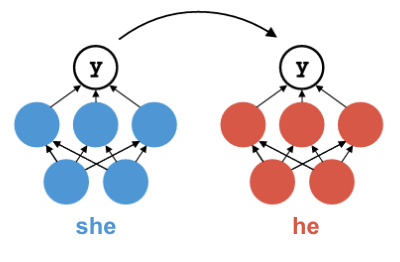

> **Total effect** measures the change in $y$ after swapping out all attention heads associated with the gendered pronoun. The magnitude of the total effect indicates how "successful" the intervention is. A larger total effect indicates a higher chance of predicting the anti-stereotypical candidate.

In the above example, this would involve swapping out all attention heads associated with _she_ in the original prompt to attention heads associated with _he_ in the new prompt. Thus, a larger total effect would mean there is a higher chance of predicting _was screaming_ as a response to our original prompt.

$$\textbf{TE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \frac{\textbf{y}_{\texttt{set-gender}}(u) - \textbf{y}_{\texttt{null}}(u)}{\textbf{y}_{\texttt{null}}(u)}$$


In [ ]:
def total_effect(model, base):
  base_string_tokens_she = model.to_tokens(base['base_string'].format(base['female_pronoun']), prepend_bos = False)
  base_string_tokens_he = model.to_tokens(base['base_string'].format(base['male_pronoun']), prepend_bos = False)

  female_occupation_continuation_tokens = model.to_tokens(base['female_occupation_continuation'], prepend_bos = False)
  male_occupation_continuation_tokens = model.to_tokens(base['male_occupation_continuation'], prepend_bos = False)

  she_female_occupation_logit = model(torch.concat((base_string_tokens_she, female_occupation_continuation_tokens), dim = 1)[:,:-1], return_type = 'logits')
  she_male_occupation_logit = model(torch.concat((base_string_tokens_she, male_occupation_continuation_tokens), dim = 1)[:,:-1], return_type = 'logits')
  he_female_occupation_logit = model(torch.concat((base_string_tokens_he, female_occupation_continuation_tokens), dim = 1)[:,:-1], return_type = 'logits')
  he_male_occupation_logit = model(torch.concat((base_string_tokens_he, male_occupation_continuation_tokens), dim = 1)[:,:-1], return_type = 'logits')


  she_female = get_probability_multi_token(she_female_occupation_logit, base_string_tokens_she, female_occupation_continuation_tokens)
  she_male = get_probability_multi_token(she_male_occupation_logit, base_string_tokens_she, male_occupation_continuation_tokens)
  he_male = get_probability_multi_token(he_male_occupation_logit, base_string_tokens_he, male_occupation_continuation_tokens)
  he_female = get_probability_multi_token(he_female_occupation_logit, base_string_tokens_he, female_occupation_continuation_tokens)


  total_effect = (he_male/he_female)/(she_male/she_female) - 1

  return total_effect

#### Unit Tests


In [ ]:
np.testing.assert_approx_equal(total_effect(model, test_example1), 0.6669689416)
np.testing.assert_approx_equal(total_effect(model, test_example2), -0.089053630)

In [ ]:
def get_total_effect(model, bases):
  return torch.mean(torch.stack([total_effect(model, i) for i in bases]))

In [ ]:
total_effect = get_total_effect(model, examples_selection)

In [ ]:
print(total_effect)

tensor(0.8747)


## Attention Intervention

### Direct Effect

 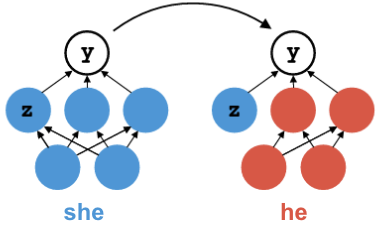

> **Direct effect** measures the change in $y$ after swapping out all attention heads associated with the gendered pronoun but one.

For the above example, you can think of the direct effect as how much more the model predicts "was screaming" for the original prompt after swapping out **all but one** attention head.

$$\textbf{NDE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \mathbb{E}\left[\frac{\textbf{y}_{\texttt{set-gender}, z_{\texttt{null}(u)}}(u) }{\textbf{y}_{\texttt{null}}(u)} - 1\right]$$



### Indirect Effect

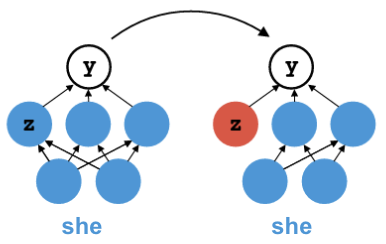

> **Indirect effect** measures the change in $y$ after swapping out a single attention head associated with the gendered pronoun.

For the above example, you can think of the indirect effect as how much more the model predicts "was screaming" for the original prompt after swapping out a **single** attention head.

$$\textbf{NIE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \mathbb{E}\left[\frac{\textbf{y}_{\texttt{null}, z_{\texttt{set-gender}(u)}}(u) }{\textbf{y}_{\texttt{null}}(u)} - 1\right]$$

In [ ]:
def hook_all_attention_patterns(
    attn_pattern, #"nurse"
    hook,
    alt_cache, #"man"
    layer,
    head_idx
):
    # modify attn_pattern inplace, at head_idx
    attn_pattern[:, head_idx, :, :]  = alt_cache[hook.name][:, head_idx, :, :]
    return attn_pattern

# p([clean the trunk) | he) and p([is grateful | he)
def attention_intervention_single_input(model, token_context, token_candidate, alt_cache, layer, head_idx):
  temp_hook_fn = partial(hook_all_attention_patterns, alt_cache = alt_cache, layer = layer, head_idx=head_idx)

  logits = model.run_with_hooks(torch.concat((token_context, token_candidate), dim = 1),
                 fwd_hooks=[(f'blocks.{layer}.attn.hook_pattern', temp_hook_fn)],
                 return_type="logits")

  prob = get_probability_multi_token(logits, token_context, token_candidate)
  return prob

In [ ]:
def get_token(base):
  base_string_tokens_she = model.to_tokens(base['base_string'].format(base['female_pronoun']), prepend_bos = False)
  base_string_tokens_he = model.to_tokens(base['base_string'].format(base['male_pronoun']), prepend_bos = False)

  female_occupation_continuation_tokens = model.to_tokens(base['female_occupation_continuation'],prepend_bos = False)
  male_occupation_continuation_tokens = model.to_tokens(base['male_occupation_continuation'], prepend_bos = False)

  return base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens

In [ ]:
def get_tokens_full_sentence(base):

  male_male_full = model.to_tokens(base['base_string'].format(base['male_pronoun'])  + base['male_occupation_continuation'], prepend_bos = False)
  male_female_full = model.to_tokens(base['base_string'].format(base['male_pronoun'])  + base['female_occupation_continuation'], prepend_bos = False)
  female_male_full = model.to_tokens(base['base_string'].format(base['female_pronoun'])  + base['male_occupation_continuation'], prepend_bos = False)
  female_female_full = model.to_tokens(base['base_string'].format(base['female_pronoun']) + base['female_occupation_continuation'], prepend_bos = False)
  return male_male_full, male_female_full, female_male_full, female_female_full


In [ ]:
def attention_intervention_two_prob(model, base, male_con_cache, female_con_cache, layer, head_idx, type_):

  base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens = get_token(base)

  if type_ == "indirect":
    y_stereo_set_gender = attention_intervention_single_input(model,
                                                              base_string_tokens_she,
                                                              female_occupation_continuation_tokens,
                                                              female_con_cache,
                                                              layer,
                                                              head_idx)
    y_anti_set_gender = attention_intervention_single_input(model,
                                                            base_string_tokens_she,
                                                            male_occupation_continuation_tokens,
                                                            male_con_cache,
                                                            layer,
                                                            head_idx)

  if type_ == "direct":
    y_stereo_set_gender = attention_intervention_single_input(model,
                                                              base_string_tokens_he,
                                                              female_occupation_continuation_tokens,
                                                              female_con_cache,
                                                              layer,
                                                              head_idx)
    y_anti_set_gender = attention_intervention_single_input(model,
                                                            base_string_tokens_he,
                                                            male_occupation_continuation_tokens,
                                                            male_con_cache,
                                                            layer,
                                                            head_idx)

  return y_anti_set_gender/y_stereo_set_gender

In [ ]:
def run_through_all_head(model, base, type_):

  base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens = get_token(base)

  male_male_full, male_female_full, female_male_full, female_female_full = get_tokens_full_sentence(base)

  logits_he_male, he_male_con_cache = model.run_with_cache(male_male_full)
  logits_he_female, he_female_con_cache = model.run_with_cache(male_female_full)
  logits_she_male, she_male_con_cache = model.run_with_cache(female_male_full)
  logits_she_female, she_female_con_cache = model.run_with_cache(female_female_full)

  prob_she_male = get_probability_multi_token(logits_she_male, base_string_tokens_she, male_occupation_continuation_tokens)
  prob_she_female = get_probability_multi_token(logits_she_female, base_string_tokens_she, female_occupation_continuation_tokens)

  y_null = prob_she_male/prob_she_female

  all_layers = []
  for layer in range(model.cfg.n_layers):
    this_layer = []
    for head_idx in range(model.cfg.n_heads):
      if type_ == "indirect":
        male_con_cache =  he_male_con_cache
        female_con_cache =  he_female_con_cache
      if type_ == "direct":
        male_con_cache =  she_male_con_cache
        female_con_cache =  she_female_con_cache

      y_set_gender = attention_intervention_two_prob(model, base, male_con_cache, female_con_cache, layer, head_idx, type_)
      this_layer.append(y_set_gender/y_null - 1)
    all_layers.append(torch.stack(this_layer))
  return torch.stack(all_layers)

In [ ]:
from tqdm import tqdm
def run_with_all_examples(model, bases, type_):
  return torch.mean(torch.stack([run_through_all_head(model, base, type_) for base in tqdm(bases)]), dim = 0)

## Visualization

### Indirect Effect

In [ ]:
indirect = run_with_all_examples(model, examples_selection, "indirect")

100%|██████████| 10/10 [01:20<00:00,  8.05s/it]


In [ ]:
direct = run_with_all_examples(model, examples_selection, "direct")

100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


In [ ]:
imshow(
    indirect,
    title="Indirect Effect With Attention Intervention", labels={"x":"Head", "y":"Layer"}, zmax = 0.1, zmin = -0.1
)

In [ ]:
result_bar = torch.sum(indirect, dim=1)

In [ ]:
bar(result_bar, labels={"x":"Layer", "y":"Indirect Effect"})

### Direct Effect + Indirect Effect = Total Effect

In [ ]:
def selected_head(difference, num_head, topk = 5):
  # Specify that you want to pick the top 5 values
  top_values, top_indices = torch.topk(difference.view(-1), k=topk)


  # Reshape the indices to get their row and column coordinates in the original matrix
  layer_idx = top_indices // num_head
  head_idx = top_indices % num_head

  selected = list(zip(layer_idx.tolist(), head_idx.tolist()))

  return selected

In [ ]:
random_selected_heads = selected_head(indirect, 12, 10)
indirect_s = [indirect[i[0], i[1]].item() for i in random_selected_heads]
direct_s = [direct[i[0], i[1]].item() for i in random_selected_heads]


In [ ]:
from pandas import DataFrame as df
import plotly.graph_objects as go

def show_sum(head, indirect_s, direct_s, total):
  pd_dict = df.from_dict({"head": [str(i) for i in head], "indirect": indirect_s, "direct": direct_s, "total": [total for i in range(len(direct_s))]})
  fig = px.bar(pd_dict, x="head", y=["indirect", "direct"], color_discrete_sequence=['pink', 'skyblue'])
  line = px.line(pd_dict, x="head", y=["total"])
  line.update_traces(line=dict(dash='dash', color='orange'))
  fig.add_trace(line.data[0])
  fig.update_layout(
    title='Decompose Effect',
    xaxis_title='selected head',
    yaxis_title='effect'  # Change this label to your desired name
)
  fig.show()

In [ ]:
show_sum(random_selected_heads, indirect_s, direct_s, total_effect)

## Top K selection

In [ ]:
# p([clean the trunk) | he) and p([is grateful | he)
def attention_intervention_top_k(model, sentence, token_context, token_candidate, alt_cache, selected_head):
  hook = []
  for layer in range(model.cfg.n_layers):
    for head_idx in range(model.cfg.n_heads):
      if (layer, head_idx) in selected_head:
        temp_hook_fn = partial(hook_all_attention_patterns, alt_cache = alt_cache, layer = layer, head_idx=head_idx)
        hook.append((f'blocks.{layer}.attn.hook_pattern', temp_hook_fn))

  logits = model.run_with_hooks(sentence, fwd_hooks=hook,return_type="logits")

  prob = get_probability_multi_token(logits.detach().cpu(), token_context, token_candidate)
  return prob

In [ ]:
def attention_intervention_two_prob_top_k(model, base, male_con_cache, female_con_cache, selected, type_, graph = True):

  base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens = get_token(base)
  male_male_full, male_female_full, female_male_full, female_female_full = get_tokens_full_sentence(base)


  if type_ == "indirect":
    base_string_tokens = base_string_tokens_she
    token_full_female_con = female_female_full
    token_full_male_con = female_male_full

  if type_ == "direct":
    base_string_tokens = base_string_tokens_he
    token_full_female_con = male_female_full
    token_full_male_con = male_male_full

  y_stereo_set_gender = attention_intervention_top_k(model,
                                                     token_full_female_con,
                                                     base_string_tokens,
                                                     female_occupation_continuation_tokens,
                                                     female_con_cache,
                                                     selected)

  y_anti_set_gender = attention_intervention_top_k(model,
                                                  token_full_male_con,
                                                  base_string_tokens,
                                                  male_occupation_continuation_tokens,
                                                  male_con_cache,
                                                  selected)

  if graph:
    return y_anti_set_gender/y_stereo_set_gender
  else:
    return y_anti_set_gender, y_stereo_set_gender

# model: HookTransformer
# the base: a list of json of len as the batch_size
# type_: either "indirect" and "direct"

def run_through_all_head_topk(model, base, selected, type_, graph = True):

  #"-------------------- BATCH INPUT -------------------------"
  base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens = get_token(base)
  male_male_full, male_female_full, female_male_full, female_female_full = get_tokens_full_sentence(base)
  #"-------------------- GET CACHE WITH BATCH ---------------------"
  logits_he_male, he_male_con_cache = model.run_with_cache(male_male_full)
  logits_he_female, he_female_con_cache = model.run_with_cache(male_female_full)
  logits_she_male, she_male_con_cache = model.run_with_cache(female_male_full)
  logits_she_female, she_female_con_cache = model.run_with_cache(female_female_full)

  prob_she_male = get_probability_multi_token(logits_she_male.detach().cpu(), base_string_tokens_she, male_occupation_continuation_tokens)
  prob_she_female = get_probability_multi_token(logits_she_female.detach().cpu(), base_string_tokens_she, female_occupation_continuation_tokens)

  y_null = prob_she_male/prob_she_female

  if type_ == "indirect":
      male_con_cache =  he_male_con_cache
      female_con_cache =  he_female_con_cache
  if type_ == "direct":
      male_con_cache =  she_male_con_cache
      female_con_cache =  she_female_con_cache
  y_set_gender =  attention_intervention_two_prob_top_k(model, base, male_con_cache, female_con_cache, selected, type_, graph)

  if graph:
    return y_set_gender/y_null - 1
  else:
    return prob_she_male, prob_she_female, y_set_gender[0], y_set_gender[1]



In [ ]:
# Create a scatter plot
def top_k_display(model, examples_selection, topk = 10):
  mean_indirect_all_heads = torch.mean(torch.stack([run_through_all_head_topk(
    model, example, selected_head(indirect, 12, topk = 144), "indirect") for example in tqdm(examples_selection)]))

  result = []
  for i in range(topk):
    mean_indirect_all_heads_indi = torch.mean(torch.stack([run_through_all_head_topk(
    model, example, selected_head(indirect, 12, topk = i), "indirect") for example in tqdm(examples_selection)]))
    result.append(mean_indirect_all_heads_indi.item())

  return mean_indirect_all_heads, result

def graph(mean_indirect_all_heads, result, topk = 10):
  pd_dict = df.from_dict({"head": range(topk), "indirect_effect": result, "total_indirect": [mean_indirect_all_heads for i in range(len(result))]})
  fig = px.line(pd_dict, x="head", y = ["indirect_effect"], title="Head Selection in GPT2-small on Winobias")
  line = px.line(pd_dict, x="head", y=["total_indirect"])
  line.update_traces(line=dict(dash='dash', color='orange'))
  fig.add_trace(line.data[0])
  fig.update_layout(
    xaxis_title='number of head',
    yaxis_title='mean indirect effect'  # Change this label to your desired name
)
  fig.show()

In [ ]:
mean_indirect_all_heads, result = top_k_display(model, examples_selection, 15)

100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


In [ ]:
graph(mean_indirect_all_heads, result, 15)

##See some final results

From the graph above, we can observe with only the top 7 heads, we can achieve the same indirect effect just as swapping all the heads.
<br> Here, we will see the difference in the probability of `"she" + male_pronoun_continuation` before and after the top 7 heads intervention

In [ ]:
def get_table(model,  examples_selection):
  change_original_she_male = []
  change_original_she_female = []
  change_intervene_she_male = []
  change_intervene_she_female = []
  ratio_before = []
  ratio_after = []
  ratio_he = []
  sentence = []
  for i, example in enumerate(examples_selection):
    prob_she_male, prob_she_female, y_anti_set_gender, y_stereo_set_gender = run_through_all_head_topk(model, example, selected_head(indirect, 12, topk = 7), "indirect", False)
      #"-------------------- BATCH INPUT -------------------------"
    base_string_tokens_she, base_string_tokens_he, female_occupation_continuation_tokens, male_occupation_continuation_tokens = get_token(example)
    male_male_full, male_female_full, female_male_full, female_female_full = get_tokens_full_sentence(example)
    #"-------------------- GET CACHE WITH BATCH ---------------------"
    logits_he_male, he_male_con_cache = model.run_with_cache(male_male_full)
    logits_he_female, he_female_con_cache = model.run_with_cache(male_female_full)

    prob_he_male = get_probability_multi_token(logits_he_male.detach().cpu(), base_string_tokens_he, male_occupation_continuation_tokens)
    prob_he_female = get_probability_multi_token(logits_he_female.detach().cpu(), base_string_tokens_he, female_occupation_continuation_tokens)

    change_original_she_male.append(prob_she_male.item())
    change_original_she_female.append(prob_she_female.item())
    change_intervene_she_male.append(y_anti_set_gender.item())
    change_intervene_she_female.append(y_stereo_set_gender.item())

    ratio_before.append(prob_she_male.item() /prob_she_female.item())
    ratio_after.append(y_anti_set_gender.item() /y_stereo_set_gender.item())
    ratio_he.append(prob_he_male.item() / prob_he_female.item())
    sentence.append((example['male_occupation'], example['female_occupation']))

    result = df.from_dict({"input": sentence,
                        #"original_she_male": change_original_she_male,
                        #"original_she_female": change_original_she_female,
                        #"intervene_she_male": change_intervene_she_male,
                        #"intervene_she_female": change_intervene_she_female,
                        "ratio_before_intervention": ratio_before,
                        "ratio_after_intervention": ratio_after,
                        'ratio_he': ratio_he
                        }
                        )
  return result


In [ ]:
get_table(model, examples_selection)

,input,ratio_before_intervention,ratio_after_intervention,ratio_he
0,"(guard, nurse)",0.137171,0.405438,0.376352
1,"(manager, assistant)",0.321363,0.401476,0.708260
2,"(carpenter, auditor)",2.148038,3.331288,4.247296
3,"(driver, housekeeper)",2.037029,2.473878,3.560684
4,"(manager, teacher)",0.743562,1.125873,1.279436
5,"(driver, librarian)",5.631604,8.704669,9.567429
6,"(lawyer, cleaner)",0.511052,0.549578,0.866741
7,"(sheriff, accountant)",0.189794,0.197534,0.318077
8,"(farmer, nurse)",9.094800,18.546369,15.160716
9,"(ceo, cleaner)",0.891363,1.289613,1.440605
